In [1]:
%matplotlib inline
import seaborn as sns; #sns.set(style="ticks", color_codes=True)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import scipy
style.use('fast')
from datetime import datetime
import re
import os

sns.set_style('ticks',{'legend.frameon':True} )
sns.set_palette('colorblind')
FIG_SIZE = (12, 3)
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['text.usetex'] = True

plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['axes.labelsize']= 22

PALETTE_BASE = sns.color_palette('muted', n_colors=12)
blue=PALETTE_BASE[0]
green=PALETTE_BASE[1] 
red=PALETTE_BASE[2] 
purple=PALETTE_BASE[3]
version_colors=['orange',red, 'gray']

In [2]:
# Cliff's Delta
from __future__ import division
 
def cliffsDelta(lst1,lst2,
                dull = [0.147, # small
                        0.33,  # medium
                        0.474 # large
                        ][0] ): 
  "Returns true if there are more than 'dull' differences"
  m, n = len(lst1), len(lst2)
  lst2 = sorted(lst2)
  j = more = less = 0
  for repeats,x in runs(sorted(lst1)):
    while j <= (n - 1) and lst2[j] <  x: 
      j += 1
    more += j*repeats
    while j <= (n - 1) and lst2[j] == x: 
      j += 1
    less += (n - j)*repeats
  d= (more - less) / (m*n)
  f=abs(d)  > dull
  print("d="+str(d))#+' '+str(f))
  return abs(d)  > dull
   
def runs(lst):
  "Iterator, chunks repeated values"
  for j,two in enumerate(lst):
    if j == 0:
      one,i = two,0
    if one!=two:
      yield j - i,one
      i = j
    one=two
  yield j - i + 1,two
  
def _cliffsDelta():
  "demo function"
  lst1=[1,2,3,4,5,6,7]
  for r in [1.01,1.1,1.21, 1.5, 2]:
    lst2=map(lambda x: x*r,lst1)
    #return lst2
    #print(lst2,cliffsDelta(lst1,lst2)) # should return False

# LOAD DATA

In [2]:
technical_lag=pd.read_csv('../../../jsep2018/csv/repos/all_repos_lag.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)
technical_lag.drop([#'release_type',
    'used_version',
                    'last_today','last_available','date_last_today'],
                   axis=1, inplace=True)
print(len(technical_lag))
technical_lag.head(2)

ValueError: labels ['used_version' 'last_today' 'last_available' 'date_last_today'] not contained in axis

In [111]:
technical_lag.repo.drop_duplicates().size

656686

In [6]:
#technical_lag.to_csv('../../../../REPOS_LAG.csv', index=False, sep=';')

In [11]:
first_date="2010-12-20"
last_date="2018-03-12"
date_period = pd.to_datetime(first_date), pd.to_datetime(last_date)


In [10]:
technical_lag['constraint_type']=technical_lag['constraint'].apply(lambda x: 
                                                     'tilde' if '~' in x
                                                       else 'caret' if '^' in x   
                                                      else 'latest' if str(x).replace(' ','').lower()=='x' 
                                                       else 'latest' if str(x).replace(' ','')=='*' 
                                                       else 'latest' if str(x).replace(' ','')=='latest' 
                                                       else 'latest' if str(x).replace(' ','').lower()=='x.x.x' 
                                                       else 'latest' if str(x).replace(' ','')=='*.*.*'
                                                       else 'strict' if len(str(x).split('.'))==3 and str(x).split('.')[0].replace('v','').replace(' ','').replace('=','').isdigit() and str(x).split('.')[1].isdigit() and str(x).split('.')[2].isdigit() 
                                                      else 'other')

In [114]:
a=technical_lag.groupby('kind').count()
a*100/len(technical_lag)

,dependency,constraint,date,repo,date_used_version,date_last_available,version_lag
kind,,,,,,,
development,48.498691,48.498691,48.498691,48.498691,48.498691,48.498691,48.498691
optional,0.050046,0.050046,0.050046,0.050046,0.050046,0.050046,0.050046
peer,0.142428,0.142428,0.142428,0.142428,0.142428,0.142428,0.142428
runtime,51.308834,51.308834,51.308834,51.308834,51.308834,51.308834,51.308834


In [8]:
a

,dependency,constraint,date,repo,date_used_version,date_last_available,version_lag,constraint_type
kind,,,,,,,,
development,5358989,5358989,5358989,5358989,5358989,5358989,5358989,5358989
optional,5530,5530,5530,5530,5530,5530,5530,5530
peer,15738,15738,15738,15738,15738,15738,15738,15738
runtime,5669503,5669503,5669503,5669503,5669503,5669503,5669503,5669503


In [12]:
technical_lag=technical_lag.query('kind!="optional" and kind!="peer"')
technical_lag['kind']=technical_lag['kind'].apply(lambda x: x.capitalize())

In [6]:
df_tmp=technical_lag.groupby(['constraint_type','kind']).count()[['constraint']].reset_index()
#l=float(len(technical_lag))
#df_tmp['constraint']=df_tmp['constraint'].apply(lambda x: x*100.0/l)


In [13]:
df_tmp.groupby(['constraint_type']).sum()

,constraint
constraint_type,
caret,51.044884
latest,1.869376
other,3.037052
strict,28.469386
tilde,15.579301


In [117]:
df_tmp.groupby(['constraint_type']).sum()

,constraint
constraint_type,
caret,5638452
latest,208724
other,339947
strict,3142197
tilde,1720440


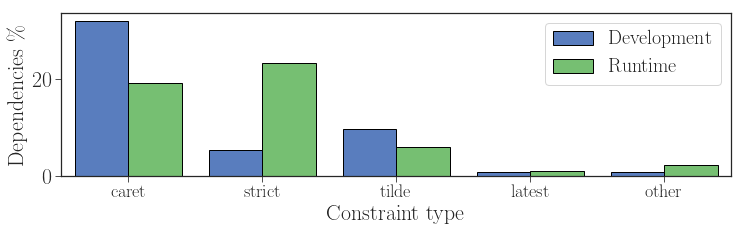

In [35]:
ax = sns.barplot(x="constraint_type", y="constraint", hue="kind", palette='muted', data=df_tmp,
                order=['caret','strict','tilde','latest','other'])
ax.figure.set_size_inches(12,3)
ax.set_xlabel('Constraint type')
ax.set_ylabel('Dependencies \%')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend( loc='upper right', bbox_to_anchor=(1, 1), fontsize=20)#,ncol=3)#, fancybox=True, shadow=True)

In [24]:
creation_date=technical_lag[['repo','date']].drop_duplicates()
creation_date['date']=creation_date['date'].apply(lambda x: x.split('-')[0]+'-'+x.split('-')[1])

creation_date['date']=pd.to_datetime(creation_date['date'])
creation_date=creation_date.groupby('date').count()*100/len(creation_date)
creation_date['repo']=creation_date['repo'].cumsum()

In [27]:
technical_lag.query('date<"2009"')

,dependency,constraint,date,repo,kind,date_used_version,date_last_available,version_lag,constraint_type


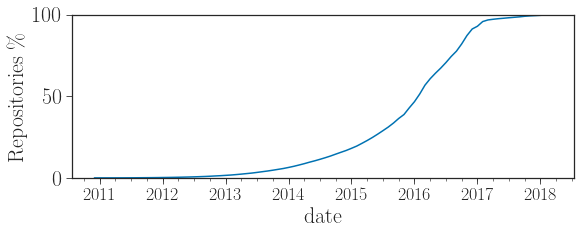

In [34]:
ax=creation_date.reset_index().plot(y="repo", x='date', legend="")
ax.set_ylim(0,100)
ax.set_ylabel('Repositories \%')
ax.figure.set_size_inches(9,3)
#ax.vlines(11, 0,100, colors='orange', linestyles='dashed', alpha=1)

# Technical lag > 0

In [13]:
technical_lag_outdated=technical_lag.query('version_lag!="0,0,0"').query('constraint_type!="latest"')
len(technical_lag_outdated)*100/len(technical_lag)

38.94421830291938

In [8]:
len(technical_lag_outdated)

4294960

In [14]:
df_tmp2=technical_lag_outdated.groupby(['kind']).count()[['constraint']]


In [15]:
df_tmp2*100/len(technical_lag_outdated)

,constraint
kind,
Development,46.517663
Runtime,53.482337


In [11]:
df_tmp=technical_lag_outdated.groupby(['constraint_type','kind']).count()[['constraint']].reset_index()
l=float(len(technical_lag_outdated))
df_tmp['constraint']=df_tmp['constraint'].apply(lambda x: x*100.0/l)
df_tmp

,constraint_type,kind,constraint
0,caret,Development,22.981006
1,caret,Runtime,9.729497
2,other,Development,0.884036
3,other,Runtime,2.685054
4,strict,Development,8.225571
5,strict,Runtime,33.049481
6,tilde,Development,14.427049
7,tilde,Runtime,8.018305


In [62]:
df_tmp.groupby(['constraint_type']).sum()

,constraint
constraint_type,
caret,32.710503
other,3.569090
strict,41.275053
tilde,22.445355


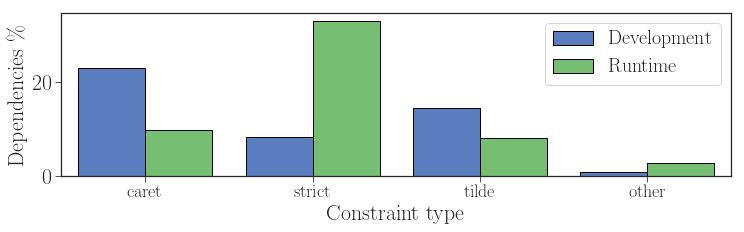

In [9]:
ax = sns.barplot(x="constraint_type", y="constraint", hue="kind", palette='muted', data=df_tmp,
                order=['caret','strict','tilde','other'])
ax.figure.set_size_inches(12,3)
ax.set_xlabel('Constraint type')
ax.set_ylabel('Dependencies \%')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend( loc='upper right', bbox_to_anchor=(1, 1), fontsize=20)#,ncol=3)#, fancybox=True, shadow=True)
ax.figure.savefig('../../../../jsep18technicallag/figures/constraints_repos.eps', bbox_inches='tight', facecolor='white')

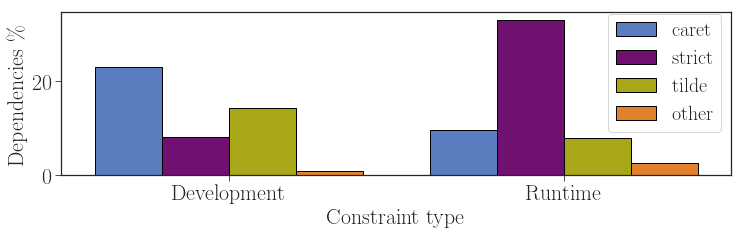

In [13]:
ax = sns.barplot(x="kind", y="constraint", hue="constraint_type", palette=[blue,"purple",'y','#ff7f0e'], data=df_tmp,
                hue_order=['caret','strict','tilde','other'])
ax.figure.set_size_inches(12,3)
ax.set_xlabel('Constraint type')
ax.set_ylabel('Dependencies \%')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend( loc='upper right', bbox_to_anchor=(1, 1.05), fontsize=20)#,ncol=3)#, fancybox=True, shadow=True)
ax.figure.savefig('../../../../jsep18technicallag/figures/constraints_repos.png', bbox_inches='tight', facecolor='white')

# Aggregate time lag

In [13]:
time_lag=technical_lag_outdated[['repo','kind','date']]

In [15]:
time_lag['time_lag']=(pd.to_datetime(technical_lag_outdated['date_last_available']) 
                      - pd.to_datetime(technical_lag_outdated['date_used_version'])).dt.days

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
time_lag_max=time_lag.groupby(['repo','kind','date']).agg('max').reset_index()

In [68]:
scipy.stats.mannwhitneyu(time_lag_max.query('kind=="Development"').time_lag,time_lag_max.query('kind=="runtime"').time_lag)

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:4897: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


MannwhitneyuResult(statistic=0.0, pvalue=0.0)

In [70]:
cliffsDelta(time_lag_max.query('kind=="Development"').time_lag,time_lag_max.query('kind=="Runtime"').time_lag)

d=0.10936434451532925


False

In [68]:
time_lag_max.query('time_lag!=0').query('kind=="Runtime"').time_lag.median()

236.0

In [10]:
time_lag_max.query('time_lag!=0').query('kind=="Development"').time_lag.median()

296.0

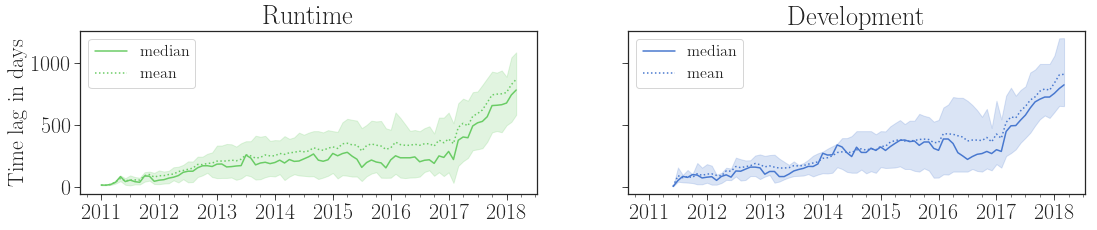

In [17]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(18,3)
time_lag_max['date']=pd.to_datetime(time_lag_max['date'])
for index, genre in enumerate(['Runtime','Development']):
    size=[12,20,70]
    df_=(time_lag_max.
         query('kind=="{}"'.format(genre)).
         groupby(pd.Grouper(key='date', freq='1M'))['time_lag'].
         describe()[['mean', '25%', '50%', '75%']] 
        )
    genre=genre.capitalize()

    if genre =="Runtime":
        color=green
    else:
        color=blue

    df_tmp=df_
    df_tmp['50%'].rename('median').plot(ax=axes[index], color=color)
    ax=df_tmp['mean'].plot(ax=axes[index],style=':',color=color)
    ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], alpha=0.2, color=color)

    ax.set(
        xlabel='',
        ylabel='Time lag in days'.format(genre),
        #xlim=date_period,
        #ylim=(0,size),
        title=genre
    )
    ax.legend(loc='upper left',  prop={'size': 16, 'weight':'bold'})
fig.savefig('../../../../jsep18technicallag/figures/time_lag_repos.png', bbox_inches='tight', facecolor='white')


# Aggregate version lag

In [25]:
version_lag=technical_lag_outdated[['repo','kind','date','version_lag']]

In [26]:
version_lag=(version_lag.
                 assign(Major=lambda d: d['version_lag'].apply(lambda x: int(x.split(',')[0])) ).
                 assign(Minor=lambda d: d['version_lag'].apply(lambda x: int(x.split(',')[1]))  ).
                 assign(Patch=lambda d: d['version_lag'].apply(lambda x: int(x.split(',')[2])) )
                )
version_lag.drop('version_lag', axis=1, inplace=True)

In [27]:
version_lag_sum=version_lag.groupby(['repo','date','kind']).agg('sum')
version_lag_sum.reset_index(inplace=True)

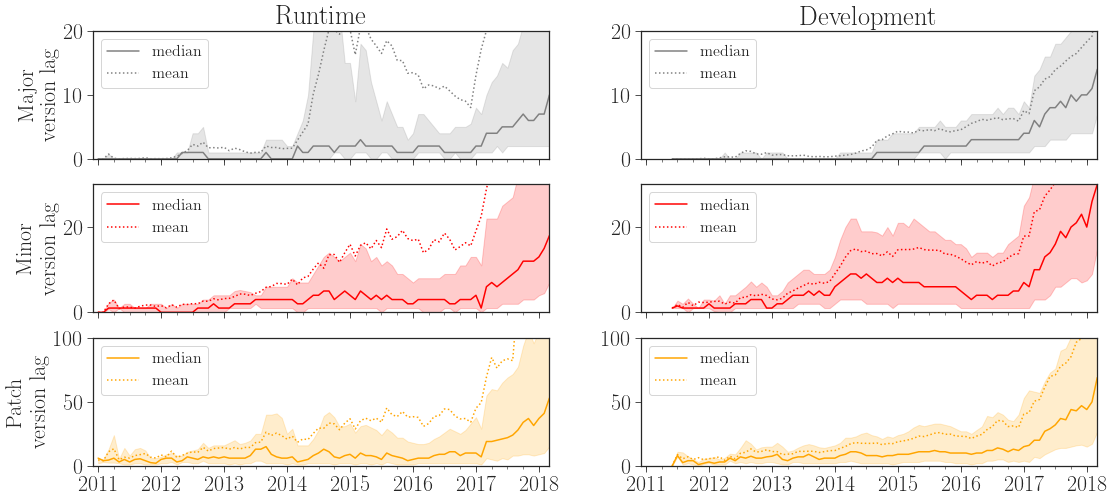

In [31]:
fig, axes = plt.subplots(3, 2, sharex=True, sharey=False)
fig.set_size_inches(18,8)
version_lag_sum['date']=pd.to_datetime(version_lag_sum['date'])
for index, genre in enumerate(['Runtime','Development']):
    size=[20,30,100]
    dfs={}
    for x in ['Patch','Minor','Major']:
        dfs[x]=(version_lag_sum.query('kind=="{}"'.format(genre)).
                groupby(pd.Grouper(key='date', freq='1M'))[x].
                describe()[['mean', '25%', '50%', '75%']] 
               )

    colors={}
    colors['Patch']='orange'
    colors['Minor']='r'
    colors['Major']='gray'


    for i, x in enumerate(['Major','Minor','Patch']):
        #fig, ax = plt.subplots()
        df_tmp=dfs[x]
        df_tmp['50%'].rename('median').plot(ax=axes[i][index], color=colors[x])
        df_tmp['mean'].plot(style=':',ax=axes[i][index], color=colors[x])
        axes[i][index].fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], color=colors[x], alpha=0.2)

        axes[i][index].set(
            xlabel='',
            ylabel='{} \n version lag'.format(x),
            xlim=date_period,
            ylim=(0,size[i]),
        )
        if i == 0:
            axes[i][index].set(title=genre)
        if index==1:
            axes[i][index].set(ylabel='')

        axes[i][index].legend(loc='upper left',  prop={'size': 16, 'weight':'bold'})

fig.savefig('../../../../jsep18technicallag/figures/version_lag_repos.pdf', bbox_inches='tight', facecolor='white')

In [73]:
for kind in ['Development','Runtime']:
    dd=version_lag_sum.query('kind=="'+kind+'"')
    print(kind)
    print(dd.Major.median(),dd.Minor.median(),dd.Patch.median())

Development
2.0 6.0 11.0
Runtime
2.0 3.0 8.0


# Constraint Evolution

In [14]:
df_tmp=technical_lag[['constraint_type','kind','date','dependency']]
df_tmp['date']=df_tmp['date'].apply(lambda x: x.split('-')[0]+'-'+x.split('-')[1])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
df_tmp=(df_tmp.groupby(['constraint_type','kind','date']).count().
        reset_index().
        merge(df_tmp[['kind','date','dependency']].groupby(['kind','date']).count().reset_index(),
              left_on="date",
              right_on='date',
              how="left")
       )

In [16]:
df_tmp=df_tmp.query('kind_x==kind_y')
df_tmp['dependency']=df_tmp['dependency_x']/df_tmp['dependency_y']
df_tmp.drop(['dependency_x','dependency_y','kind_y'], axis=1, inplace=True)
df_tmp.rename(columns={'kind_x':'kind'}, inplace=True)
df_tmp['date']=df_tmp['date'].apply(lambda x: datetime.strptime(x, "%Y-%m"))
df_tmp.head()

,constraint_type,kind,date,dependency
0,caret,Development,2014-01-01,0.000258
2,caret,Development,2014-02-01,0.008498
4,caret,Development,2014-03-01,0.060593
6,caret,Development,2014-04-01,0.121189
8,caret,Development,2014-05-01,0.161607


In [17]:
df_tmp['kind']=df_tmp['kind'].apply(lambda x: x.capitalize())
df_tmp_run=(df_tmp.query('kind=="Runtime"').drop('kind', axis=1).
    pivot(index='date', columns='constraint_type', values='dependency').
     fillna(0)
    ).reset_index()
df_tmp_run['kind']='Runtime'

df_tmp_dev=(df_tmp.query('kind=="Development"').drop('kind', axis=1).
    pivot(index='date', columns='constraint_type', values='dependency').
     fillna(0)
    ).reset_index()
df_tmp_dev['kind']='Development'
df_tmp_all=pd.concat([df_tmp_run, df_tmp_dev])


In [18]:
for x in df_tmp_all:
    if x=="date" or x=="kind":
        continue
    df_tmp_all[x]=df_tmp_all[x].apply(lambda x: float(x)*100)
df_tmp_all['date']=pd.to_datetime(df_tmp_all['date'])
df_tmp_all['kind']=df_tmp_all['kind'].apply(lambda x: x.capitalize())

In [21]:
df_tmp_all.head()

constraint_type,date,caret,latest,other,strict,tilde,kind
0,2010-12-01,0.0,0.000000,100.000000,0.000000,0.000000,Runtime
1,2011-01-01,0.0,0.000000,58.823529,41.176471,0.000000,Runtime
2,2011-02-01,0.0,18.181818,72.727273,9.090909,0.000000,Runtime
3,2011-03-01,0.0,2.222222,68.888889,22.222222,6.666667,Runtime
4,2011-04-01,0.0,5.084746,54.237288,33.898305,6.779661,Runtime


In [14]:
############# This is for packages
df_tmp_all_packages=pd.read_csv('../../../jsep2018/csv/packages/ready/constraint_evolution_num.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)
for x in df_tmp_all_packages:
    if x=="date" or x=="kind":
        continue
    df_tmp_all_packages[x]=df_tmp_all_packages[x].apply(lambda x: float(x)*100)
df_tmp_all_packages['date']=pd.to_datetime(df_tmp_all_packages['date'])
df_tmp_all_packages['kind']=df_tmp_all_packages['kind'].apply(lambda x: x.capitalize())

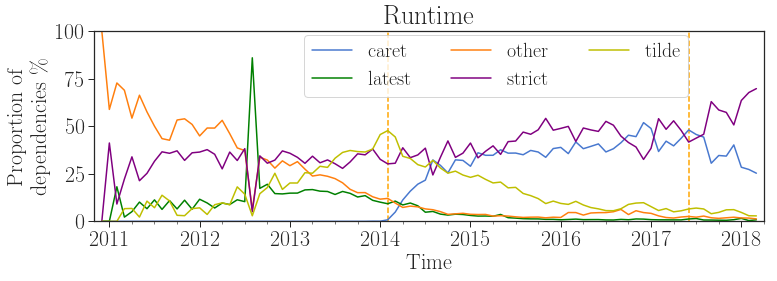

In [23]:
ax=df_tmp_all.query('kind=="Runtime"').plot(x="date",color=[blue,"g",'#ff7f0e','purple','y'],)#, ax=axes[int(i/2)][j], label=type)    

ax.set_ylabel('Proportion of\n dependencies \%')
ax.set_xlabel('Time')
ax.figure.set_size_inches(12,3.5)
plt.tick_params(axis='both', which='major', width=1)
ax.set_ylim(0,100)
ax.legend( prop={'size': 20, 'weight':'bold'}, ncol=3, bbox_to_anchor=(0.6, 0.6))
ax.set_title('Runtime')
ax.set_xlim(pd.to_datetime("2010-11-01"),pd.to_datetime("2018-04-01"))

ax.vlines(pd.to_datetime('2014-02-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)
ax.vlines(pd.to_datetime('2017-06-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)

ax.figure.savefig('/home/neglectos/Desktop/jsep18technicallag/figures/constraints_repos_runtime.pdf', bbox_inches='tight', facecolor='white')

In [38]:
df_tmp_all.rename(columns={"caret":'caret-apps','latest':'latest-apps',
                           'other':'other-apps','strict':'strict-apps',
                           'tilde':'tilde-apps'}, inplace=True)

In [39]:
df_tmp_all_packages.rename(columns={"caret":'caret-pkgs','latest':'latest-pkgs',
                           'other':'other-pkgs','strict':'strict-pkgs',
                           'tilde':'tilde-pkgs'}, inplace=True)

In [40]:
all_const=(df_tmp_all.set_index(['date','kind']).
           merge(df_tmp_all_packages.set_index(['date','kind']),
                 left_index=True,
                 right_index=True,
                 how="left")
           .fillna(0)
           .reset_index()
          )
all_const=all_const.query('kind=="Runtime"')
len(all_const)

88

In [57]:
df_tmp_all_packages.head()

,date,caret-pkgs,latest-pkgs,other-pkgs,strict-pkgs,tilde-pkgs,kind
0,2010-12-01,0.0,0.000000,96.551724,3.448276,0.000000,Runtime
1,2011-01-01,0.0,7.142857,82.080201,10.526316,0.250627,Runtime
2,2011-02-01,0.0,4.531411,81.256437,13.800206,0.411946,Runtime
3,2011-03-01,0.0,2.844037,78.165138,17.981651,1.009174,Runtime
4,2011-04-01,0.0,9.567901,74.459877,13.271605,2.700617,Runtime


In [54]:
df_tmp_all_packages=df_tmp_all_packages[[
                                        'date',
                                        'caret-pkgs',
                                        'latest-pkgs',
                                        'other-pkgs',
                                        'strict-pkgs',
                                        'tilde-pkgs',
                                        'kind']]

In [59]:
df_tmp_all=df_tmp_all.reset_index()[[
                        'date',
                        'caret-apps',
                        'latest-apps',
                        'other-apps',
                        'strict-apps',
                        'tilde-apps',
                        'kind']]
df_tmp_all.head()


constraint_type,date,caret-apps,latest-apps,other-apps,strict-apps,tilde-apps,kind
0,2010-12-01,0.0,0.000000,100.000000,0.000000,0.000000,Runtime
1,2011-01-01,0.0,0.000000,58.823529,41.176471,0.000000,Runtime
2,2011-02-01,0.0,18.181818,72.727273,9.090909,0.000000,Runtime
3,2011-03-01,0.0,2.222222,68.888889,22.222222,6.666667,Runtime
4,2011-04-01,0.0,5.084746,54.237288,33.898305,6.779661,Runtime


In [76]:
df_tmp_all.rename(columns={"caret-apps":'caret','latest-apps':'latest',
                           'other-apps':'other','strict-apps':'strict',
                           'tilde-apps':'tilde'}, inplace=True)

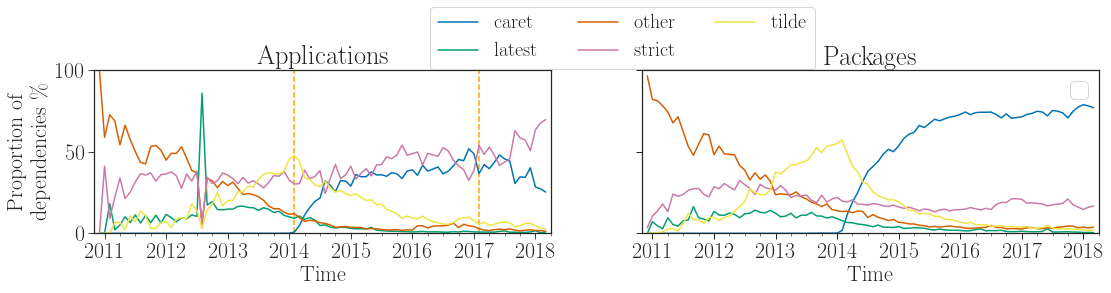

In [85]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(18,3)

ax=df_tmp_all.query('kind=="Runtime"').plot(x="date", ax=axes[0], )#, ax=axes[int(i/2)][j], label=type)    

ax.set_ylabel('Proportion of\n dependencies \%')
ax.set_xlabel('Time')
plt.tick_params(axis='both', which='major', width=1)
ax.set_ylim(0,100)
ax.legend( prop={'size': 20, 'weight':'bold'}, ncol=3, bbox_to_anchor=(1.6, 1.45))
ax.set_title('Applications')
ax.set_xlim(pd.to_datetime("2010-11-01"),pd.to_datetime("2018-04-01"))

ax.vlines(pd.to_datetime('2014-02-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)
ax.vlines(pd.to_datetime('2017-02-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)



ax=df_tmp_all_packages.query('kind=="Runtime"').plot(x="date",ax=axes[1] ,)#, ax=axes[int(i/2)][j], label=type)    

ax.set_ylabel('Proportion of\n dependencies \%')
ax.set_xlabel('Time')
plt.tick_params(axis='both', which='major', width=1)
ax.set_ylim(0,100)
ax.legend('')
ax.set_title('Packages')

ax.set_xlim(pd.to_datetime("2010-11-01"),pd.to_datetime("2018-04-01"))


fig.savefig('/home/neglectos/Desktop/jsep18technicallag/figures/constraints_apps_pkgs2.eps', bbox_inches='tight', facecolor='white')

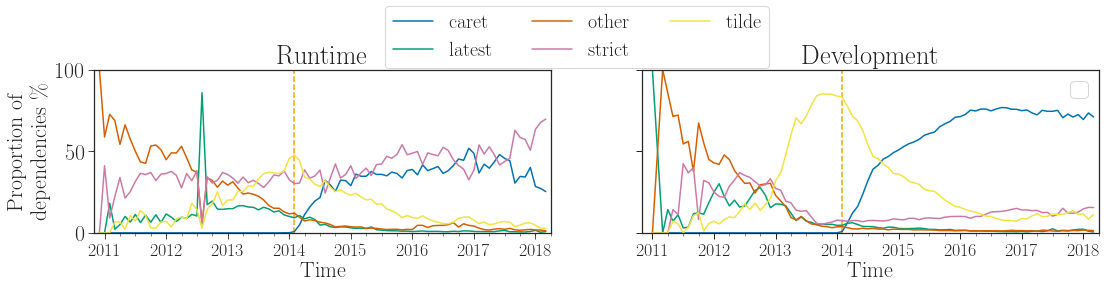

In [27]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(18,3)
for index, kind in enumerate(['Runtime','Development']):
    
    ax=df_tmp_all.query('kind=="'+kind+'"').plot(x="date",  ax=axes[index])#, ax=axes[int(i/2)][j], label=type)    

    ax.set_ylabel('Proportion of\n dependencies \%')
    ax.set_xlabel('Time')
#    ax.figure.set_size_inches(12,3.5)
    plt.tick_params(axis='both', which='major', width=1)
    ax.set_ylim(0,100)
    ax.legend( prop={'size': 20, 'weight':'bold'}, ncol=3, bbox_to_anchor=(1.5, 1.45))
    ax.set_title(kind)
    ax.set_xlim(pd.to_datetime("2010-11-01"),pd.to_datetime("2018-04-01"))
ax.legend('')

axes[0].vlines(pd.to_datetime('2014-02-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)
axes[1].vlines(pd.to_datetime('2014-02-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)


#axes[0].vlines(pd.to_datetime('2017-05-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)

#axes[0].vlines(pd.to_datetime('2016-03-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)
#axes[0].vlines(pd.to_datetime('2017-10-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)
#axes[1].vlines(pd.to_datetime('2017-10-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)
fig.savefig('/home/neglectos/Desktop/jsep18technicallag/figures/constraints_evolution_repos.pdf', bbox_inches='tight', facecolor='white')

In [18]:
technical_lag.kind.drop_duplicates()

0             runtime
1         development
353              peer
116970       optional
Name: kind, dtype: object

# Constraints Only for outdated 

In [10]:
df_tmp=technical_lag_outdated[['constraint_type','kind','date','dependency']]
df_tmp['date']=df_tmp['date'].apply(lambda x: x.split('-')[0]+'-'+x.split('-')[1])

df_tmp=(df_tmp.groupby(['constraint_type','kind','date']).count().
        reset_index().
        merge(df_tmp[['kind','date','dependency']].groupby(['kind','date']).count().reset_index(),
              left_on="date",
              right_on='date',
              how="left")
       )

df_tmp=df_tmp.query('kind_x==kind_y')
df_tmp['dependency']=df_tmp['dependency_x']/df_tmp['dependency_y']
df_tmp.drop(['dependency_x','dependency_y','kind_y'], axis=1, inplace=True)
df_tmp.rename(columns={'kind_x':'kind'}, inplace=True)
df_tmp['date']=df_tmp['date'].apply(lambda x: datetime.strptime(x, "%Y-%m"))
df_tmp.head()

df_tmp['kind']=df_tmp['kind'].apply(lambda x: x.capitalize())
df_tmp_run=(df_tmp.query('kind=="Runtime"').drop('kind', axis=1).
    pivot(index='date', columns='constraint_type', values='dependency').
     fillna(0)
    ).reset_index()
df_tmp_run['kind']='Runtime'

df_tmp_dev=(df_tmp.query('kind=="Development"').drop('kind', axis=1).
    pivot(index='date', columns='constraint_type', values='dependency').
     fillna(0)
    ).reset_index()
df_tmp_dev['kind']='Development'
df_tmp_all=pd.concat([df_tmp_run, df_tmp_dev])

for x in df_tmp_all:
    if x=="date" or x=="kind":
        continue
    df_tmp_all[x]=df_tmp_all[x].apply(lambda x: float(x)*100)
df_tmp_all['date']=pd.to_datetime(df_tmp_all['date'])
df_tmp_all['kind']=df_tmp_all['kind'].apply(lambda x: x.capitalize())

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


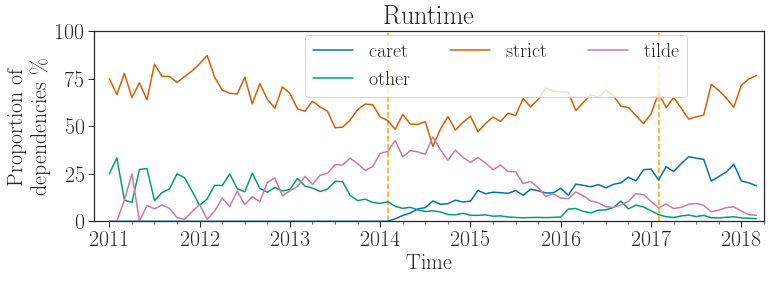

In [12]:
ax=df_tmp_all.query('kind=="Runtime"').plot(x="date",)#, ax=axes[int(i/2)][j], label=type)    

ax.set_ylabel('Proportion of\n dependencies \%')
ax.set_xlabel('Time')
ax.figure.set_size_inches(12,3.5)
plt.tick_params(axis='both', which='major', width=1)
ax.set_ylim(0,100)
ax.legend( prop={'size': 20, 'weight':'bold'}, ncol=3, bbox_to_anchor=(0.6, 0.6))
ax.set_title('Runtime')
ax.set_xlim(pd.to_datetime("2010-11-01"),pd.to_datetime("2018-04-01"))

ax.vlines(pd.to_datetime('2014-02-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)
ax.vlines(pd.to_datetime('2017-02-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)

#ax.figure.savefig('/home/neglectos/Desktop/jsep18technicallag/figures/constraints_repos_runtime.eps', bbox_inches='tight', facecolor='white')

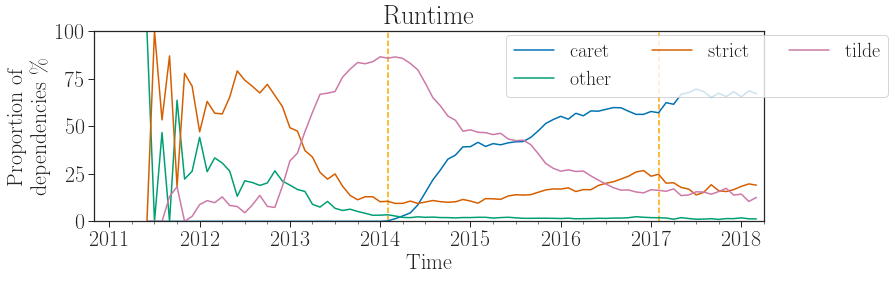

In [13]:
ax=df_tmp_all.query('kind=="Development"').plot(x="date",)#, ax=axes[int(i/2)][j], label=type)    

ax.set_ylabel('Proportion of\n dependencies \%')
ax.set_xlabel('Time')
ax.figure.set_size_inches(12,3.5)
plt.tick_params(axis='both', which='major', width=1)
ax.set_ylim(0,100)
ax.legend( prop={'size': 20, 'weight':'bold'}, ncol=3, bbox_to_anchor=(0.6, 0.6))
ax.set_title('Runtime')
ax.set_xlim(pd.to_datetime("2010-11-01"),pd.to_datetime("2018-04-01"))

ax.vlines(pd.to_datetime('2014-02-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)
ax.vlines(pd.to_datetime('2017-02-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)

#ax.figure.savefig('/home/neglectos/Desktop/jsep18technicallag/figures/constraints_repos_runtime.eps', bbox_inches='tight', facecolor='white')

# TEST IGNORE

In [32]:
versions=pd.read_csv('../../../jsep2018/csv/versions_npm_march.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)
#versions['date']=pd.to_datetime(versions['date'])
print(len(versions))
versions.head(2)

4760450


,package,version,date,release_type
0,0,0.0.0,2014-04-01,initial
1,0-,0.0.1,2017-03-06,initial


In [121]:
versions.package.drop_duplicates().size

698648

In [3]:
# Use only once: Skip
import codecs
import json as js
all_packages2=js.load(codecs.open('/home/neglectos/Desktop/_all_docs.json', 'r', 'utf-8'))
all_packages=[]
for row in all_packages2['rows']:
    all_packages.append(row['id'])


In [18]:
versions.head()

0    False
1     True
2     True
4     True
5    False
Name: package, dtype: bool

In [98]:
versions['date']=versions['date'].apply(lambda x: x.split('-')[0]+'-'+x.split('-')[1])
#versions['date']=versions['date'].apply(lambda x: x.split('-')[0]+'-'+x.split('-')[1]+'-'+x.split('-')[2][0]+'0' if x.split('-')[2][0]!='0'
#                                       else x.split('-')[0]+'-'+x.split('-')[1]+'-01')
versions['date']=pd.to_datetime(versions['date'])


In [129]:
'npm-ghost' in all_packages

False

In [99]:
mask=versions.package.isin(all_packages)
versions=versions[mask]
versions.package.drop_duplicates().size

646197

In [30]:
mask=versions.package.isin(versions.query('date>"2016"').query('release_type=="initial"').package.tolist())
versions=versions[~mask]

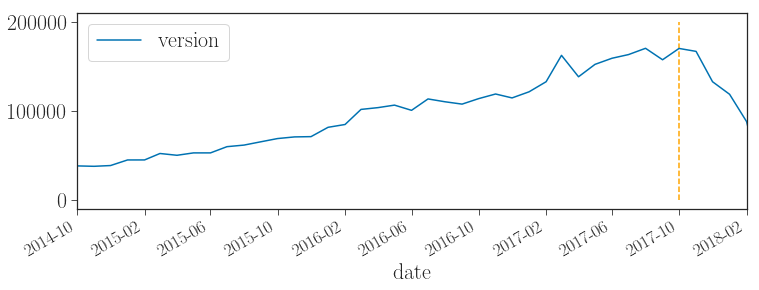

In [120]:
a=versions.groupby('date').count()[['version']].reset_index()
ax=a.plot(x='date', y="version")
ax.set_xlim(pd.to_datetime('2014-10-01'),pd.to_datetime('2018-02-01'))
ax.figure.set_size_inches(12,4)
ax.vlines(pd.to_datetime('2017-10-01'), 0,200000, colors='orange', linestyles='dashed', alpha=1)


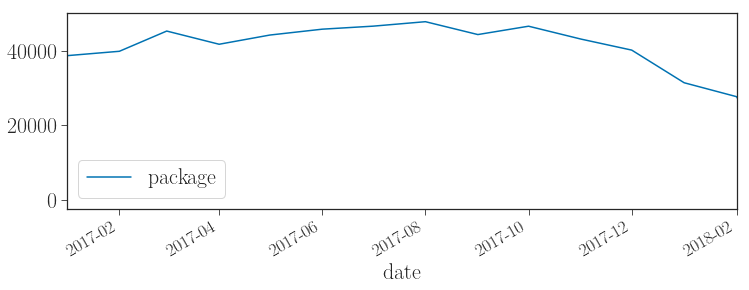

In [132]:
c=versions[['package','date']].drop_duplicates()
c=c.groupby('date').count().reset_index()
ax=c.plot(x='date', y="package")
ax.set_xlim(pd.to_datetime('2017-01-01'),pd.to_datetime('2018-02-01'))
ax.figure.set_size_inches(12,4)

In [133]:
b=(a.
   merge(c,
         left_on='date',
         right_on='date',
         how='left'
        )
  )
b.rename(columns={'package':'active packages', 'version':'created versions'}, inplace=True)


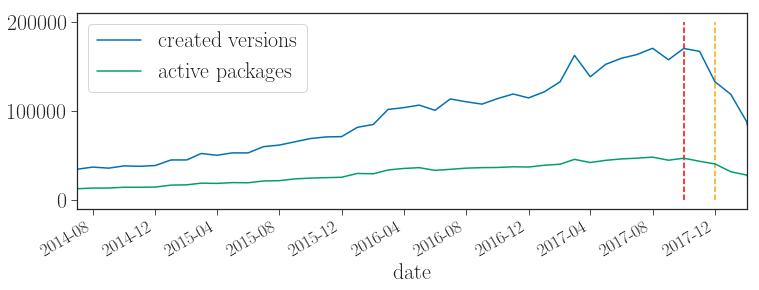

In [144]:
ax=b.set_index('date').plot()
ax.set_xlim(pd.to_datetime('2014-07-01'),pd.to_datetime('2018-02-01'))
ax.figure.set_size_inches(12,4)
ax.vlines(pd.to_datetime('2017-12-01'), 0,200000, colors='orange', linestyles='dashed', alpha=1)
ax.vlines(pd.to_datetime('2017-10-01'), 0,200000, colors='red', linestyles='dashed', alpha=1)

#ax.vlines(pd.to_datetime('2017-11-08'), 0,20000, colors='orange', linestyles='dashed', alpha=1)
#ax.vlines(pd.to_datetime('2017-11-28'), 0,20000, colors='orange', linestyles='dashed', alpha=1)
#ax.vlines(pd.to_datetime('2018-01-06'), 0,20000, colors='orange', linestyles='dashed', alpha=1)




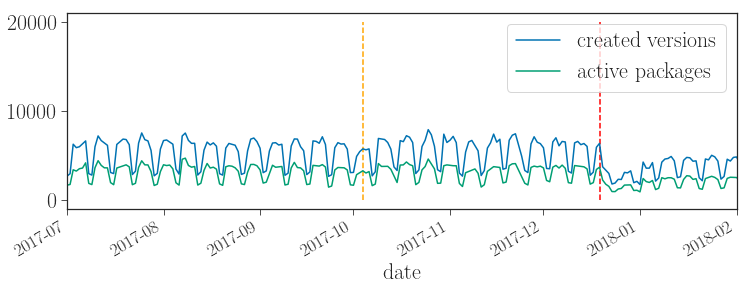

In [129]:
ax2=b.set_index('date').plot()
ax2.set_xlim(pd.to_datetime('2017-07-01'),pd.to_datetime('2018-02-01'))
ax2.figure.set_size_inches(12,4)
ax2.vlines(pd.to_datetime('2017-12-19'), 0,20000, colors='red', linestyles='dashed', alpha=1)
ax2.vlines(pd.to_datetime('2017-10-04'), 0,20000, colors='orange', linestyles='dashed', alpha=1)

#ax.vlines(pd.to_datetime('2017-11-08'), 0,20000, colors='orange', linestyles='dashed', alpha=1)
#ax.vlines(pd.to_datetime('2017-11-28'), 0,20000, colors='orange', linestyles='dashed', alpha=1)
#ax.vlines(pd.to_datetime('2018-01-06'), 0,20000, colors='orange', linestyles='dashed', alpha=1)




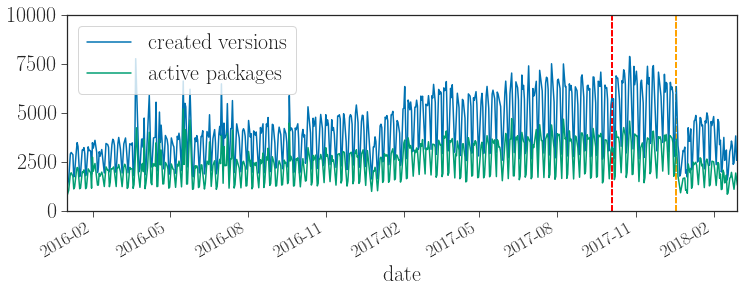

In [150]:
ax2.set_ylim(0,10000)
ax2.set_xlim(pd.to_datetime('2016-01-01'),pd.to_datetime('2018-02-28'))

ax2.vlines(pd.to_datetime('2017-12-19'), 0,20000, colors='orange', linestyles='dashed', alpha=1)
ax2.vlines(pd.to_datetime('2017-10-04'), 0,20000, colors='red', linestyles='dashed', alpha=1)
ax2.figure

In [49]:
len(versions.query('package=="bluebird"'))

215

In [33]:
versions['pre']=versions['version'].apply(lambda x: x.split('.')[2].isdigit() )

In [34]:
versions.groupby('pre').count()

,package,version,date,release_type
pre,,,,
False,409814,409816,409816,409816
True,4350564,4350634,4350634,4350634


In [35]:
len(versions)

4760450

In [37]:
409814*100/4760450

8.60872396517136

In [39]:
mask= technical_lag.constraint.isin(versions.query('pre==True').version)

In [40]:
df_tmp=technical_lag[mask]

In [42]:
len(technical_lag)

11028492